In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [2]:
data = pd.read_csv('unsupervised(elian).csv')
df = pd.DataFrame(data)

In [3]:
df.drop(columns='cluster',inplace=True)

In [4]:
df.head()

,price,availability_365,room_type,review_scores_rating,neighbourhood_group_cleansed
0,48.0,365,Private room,4.60,East Region
1,60.0,244,Private room,4.69,North-East Region
2,50.0,365,Private room,4.70,East Region
3,200.0,362,Entire home/apt,4.93,East Region
4,60.0,239,Private room,4.81,North-East Region


In [5]:
le_room = LabelEncoder()
le_region = LabelEncoder()

In [6]:
df['room_type_encoded'] = le_room.fit_transform(df['room_type'])
df['neighbourhood_group_cleansed_encoded'] =le_region.fit_transform(df['neighbourhood_group_cleansed'])

In [7]:
room_mapping = dict(zip(le_room.classes_,le_room.transform(le_room.classes_)))
region_mapping = dict(zip(le_region.classes_,le_region.transform(le_region.classes_)))

print("room type mapping: ", room_mapping)
print("region type mapping: ", region_mapping)

room type mapping:  {'Entire home/apt': 0, 'Private room': 1}
region type mapping:  {'East Region': 0, 'North Region': 1, 'North-East Region': 2, 'West Region': 3}


In [8]:
df["estimated_revenue"] = df["price"]*df["availability_365"]

df.head()

,price,availability_365,room_type,review_scores_rating,neighbourhood_group_cleansed,room_type_encoded,neighbourhood_group_cleansed_encoded,estimated_revenue
0,48.0,365,Private room,4.60,East Region,1,0,17520.0
1,60.0,244,Private room,4.69,North-East Region,1,2,14640.0
2,50.0,365,Private room,4.70,East Region,1,0,18250.0
3,200.0,362,Entire home/apt,4.93,East Region,0,0,72400.0
4,60.0,239,Private room,4.81,North-East Region,1,2,14340.0


In [9]:
df["revenue_category"] = pd.qcut(df["estimated_revenue"], q=3, labels=["low","mid","high"])
print(df[df['availability_365'] != 365]['revenue_category'].value_counts())

low     58
high    50
mid     43
Name: revenue_category, dtype: int64


In [10]:
x = df[['price','availability_365','review_scores_rating','room_type_encoded','neighbourhood_group_cleansed_encoded']]
y = df["revenue_category"]

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [14]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [15]:
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.9211
Classification Report:
              precision    recall  f1-score   support

        high       1.00      0.92      0.96        13
         low       1.00      0.85      0.92        13
         mid       0.80      1.00      0.89        12

    accuracy                           0.92        38
   macro avg       0.93      0.92      0.92        38
weighted avg       0.94      0.92      0.92        38



In [16]:
cv_scores = cross_val_score(model, x, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (5-fold): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Cross-Validation Accuracy (5-fold): 0.9421 ± 0.0510


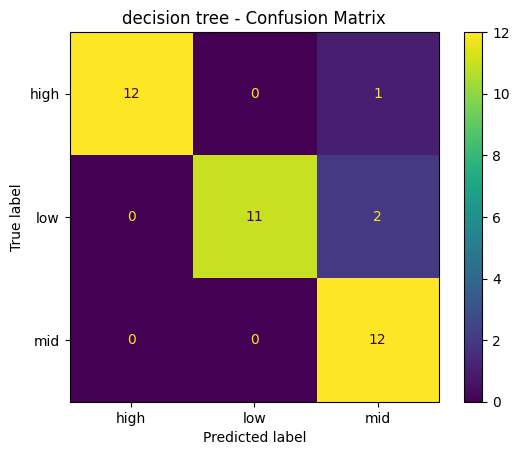

In [17]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title("decision tree - Confusion Matrix")
plt.show()

tuning

In [18]:
from sklearn.model_selection import GridSearchCV

In [19]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

In [20]:
rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [21]:
best_rf = grid_search.best_estimator_

y_pred_tuning = best_rf.predict(X_test)

from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred_tuning))
print("Classification Report:\n", classification_report(y_test, y_pred_tuning))

print("Best Parameters:", grid_search.best_params_)

cv_scores = cross_val_score(best_rf, x, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (5-fold): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Accuracy: 0.9473684210526315
Classification Report:
               precision    recall  f1-score   support

        high       1.00      1.00      1.00        13
         low       1.00      0.85      0.92        13
         mid       0.86      1.00      0.92        12

    accuracy                           0.95        38
   macro avg       0.95      0.95      0.95        38
weighted avg       0.95      0.95      0.95        38

Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Cross-Validation Accuracy (5-fold): 0.9474 ± 0.0408


In [22]:
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

cv_scores = cross_val_score(model, x, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (5-fold): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Test Accuracy: 0.9211
Classification Report:
              precision    recall  f1-score   support

        high       1.00      0.92      0.96        13
         low       1.00      0.85      0.92        13
         mid       0.80      1.00      0.89        12

    accuracy                           0.92        38
   macro avg       0.93      0.92      0.92        38
weighted avg       0.94      0.92      0.92        38

Cross-Validation Accuracy (5-fold): 0.9368 ± 0.0516


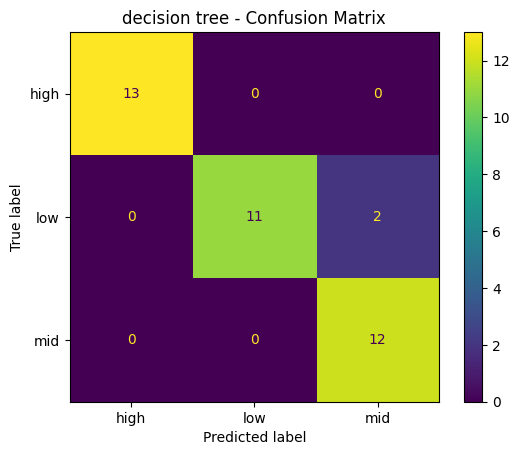

In [23]:
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("decision tree - Confusion Matrix")
plt.show()

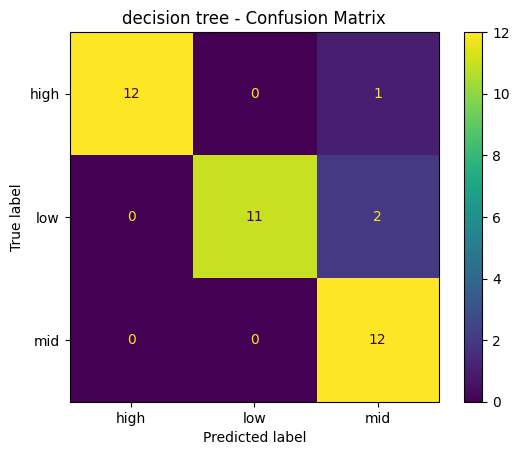

In [24]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title("decision tree - Confusion Matrix")
plt.show()

In [25]:
import joblib

# Save the trained model
joblib.dump(model, 'revenue_classifier_nocluster.pkl')

# Save encoders too (they're required for inference)
joblib.dump(le_room, 'le_room_nocluster.pkl')
joblib.dump(le_region, 'le_region_nocluster.pkl')

['le_region_nocluster.pkl']